<a href="https://colab.research.google.com/github/minjeeeko/Dacon_Predict_Daegu_Caraccident/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import datetime as dt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from functools import reduce
import pickle
plt.rc('font', family='NanumBarunGothic')

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [ ]:
path = r"/content/drive/MyDrive/data_analysis/대구 교통사고 피해 예측 AI 경진대회/data"
fpath = r"/content/drive/MyDrive/data_analysis/대구 교통사고 피해 예측 AI 경진대회/data/external_open"

In [ ]:
# 데이터 불러오기
train_data = pd.read_csv(path + "/train.csv")
test_data = pd.read_csv(path + "/test.csv")
acc = pd.read_csv(fpath + "/countrywide_accident.csv")
CCTV = pd.read_csv(fpath + "/대구 CCTV 정보.csv", encoding = 'cp949')
light = pd.read_csv(fpath + "/대구 보안등 정보.csv", encoding = 'cp949', low_memory=False)
child_protect = pd.read_csv(fpath + "/대구 어린이 보호 구역 정보.csv", encoding = 'cp949')
parking = pd.read_csv(fpath + "/대구 주차장 정보.csv", encoding = 'cp949')

In [ ]:
train = train_data.copy()
test = test_data.copy()

In [ ]:
print(test.columns)
print(train.columns)

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형'], dtype='object')
Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')


In [ ]:
cols = ['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', 'ECLO']
train = train[cols]
train.isna().sum()

ID      0
사고일시    0
요일      0
기상상태    0
시군구     0
도로형태    0
노면상태    0
사고유형    0
ECLO    0
dtype: int64

In [ ]:
train['사고일시'] = train['사고일시'].astype('datetime64')
train['사고월'] = train['사고일시'].dt.month.astype(str)
train['사고일'] = train['사고일시'].dt.day.astype(str)
train['사고시간'] = train['사고일시'].dt.hour.astype(str)

train = train.drop('사고일시', axis = 1)

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'
train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train = train.drop(columns=['시군구'])

In [ ]:
test['사고일시'] = test['사고일시'].astype('datetime64')
test['사고월'] = test['사고일시'].dt.month.astype(str)
test['사고일'] = test['사고일시'].dt.day.astype(str)
test['사고시간'] = test['사고일시'].dt.hour.astype(str)

test = test.drop('사고일시', axis = 1)

location_pattern = r'(\S+) (\S+) (\S+)'
test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])

In [ ]:
def process_location_data(df, address_column, drop_columns):
    location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
    df[['도시', '구', '동', '우편번호']] = df[address_column].str.extract(location_pattern)
    df = df.drop(drop_columns, axis=1)
    return df

In [ ]:
CCTV = process_location_data(CCTV, '소재지지번주소', ['소재지지번주소', '우편번호'])
light = process_location_data(light, '소재지지번주소', ['소재지지번주소', '우편번호'])
parking = process_location_data(parking, '소재지지번주소', ['소재지지번주소', '우편번호'])
child_protect = process_location_data(child_protect, '소재지지번주소', ['소재지지번주소', '우편번호'])

CCTV_notnull = CCTV.dropna(subset=['동'])
light_notnull = light.dropna(subset=['동'])
parking_notnull = parking.dropna(subset=['동'])
child_protect_notnull = child_protect.dropna(subset=['동'])

In [ ]:
print(CCTV_notnull.head(5))
print('-' * 110)
print(light_notnull.head(5))
print('-' * 110)
print(parking_notnull.head(5))
print('-' * 110)
print(child_protect_notnull.head(5))

  무인교통단속카메라관리번호    시도명 시군구명 도로종류 도로노선번호 도로노선명  도로노선방향          소재지도로명주소  \
0          주차12  대구광역시   남구   시도    NaN   대명로       3  대구광역시 남구 대명로 162   
1          주차13  대구광역시   남구   시도    NaN   봉덕로       3  대구광역시 남구 봉덕로 135   
2          주차14  대구광역시   남구   시도    NaN   대봉로       3  대구광역시 남구 봉덕로 134   
3          주차15  대구광역시   남구   시도    NaN   큰골길       3  대구광역시 남구 큰골길 200   
4          주차16  대구광역시   남구   시도    NaN   큰골길       3  대구광역시 남구 큰골길 243   

          위도          경도           설치장소  단속구분  제한속도  단속구간위치구분  과속단속구간길이  \
0  35.838857  128.575418  안지랑네거리1 버스정류장     4     0       NaN       NaN   
1  35.844653  128.604619         효성백년가약     4     0       NaN       NaN   
2  35.844183  128.604815       강변코오롱하늘채     4     0       NaN       NaN   
3  35.834798  128.585284         보성청록타운     4     0       NaN       NaN   
4  35.832728  128.588324          환경차고지     4     0       NaN       NaN   

   보호구역구분    설치연도     도시   구    동  
0    99.0  2010.0  대구광역시  남구  대명동  
1    99.0  2013.0  대구광역시  

In [ ]:
# CCTV의 경우, 개별 정보이기 때문에 동별로 개수 count
CCTV_num = CCTV_notnull.groupby('동').size().reset_index(name='CCTV개수')

In [ ]:
# 보안등의 경우, 동별로 설치 개수가 나타나있기 때문에 count
light_num = light_notnull.groupby('동')['설치개수'].sum()
light_num = pd.DataFrame(light_num).reset_index()
light_num.rename(columns = {'설치개수' : '보안등개수'}, inplace = True)

In [ ]:
# 주차장 일단 급지지역으로 one-hot encoding
parking_cat = pd.get_dummies(parking_notnull[['동', '급지구분']], columns=['급지구분'], prefix='급지')
parking_num = parking_notnull.groupby('동').size()
parking_num = pd.DataFrame(parking_num).reset_index()
# 그리고 주차장 개수 더하기
parking_num.rename(columns = {0 : '주차장개수'}, inplace = True)
parking_pre = pd.merge(parking_num, parking_cat, how = 'left', on = '동')
parking_pre = parking_pre.groupby('동').sum().reset_index()

In [ ]:
# 동 안에 초등학교 개수 세기
elementary_num = child_protect_notnull.groupby('동')['대상시설명'].nunique()
elementary_num = pd.DataFrame(elementary_num).reset_index()
elementary_num.rename(columns = {'대상시설명' : '초등학교개수'}, inplace = True)

In [ ]:
join_1 = pd.merge(train, CCTV_num, on = '동', how = 'left')
join_2 = pd.merge(join_1, light_num, on = '동', how = 'left')
join_3 = pd.merge(join_2, parking_pre, on = '동', how = 'left')
join_4 = pd.merge(join_3, elementary_num, on = '동', how = 'left')
train_raw = join_4.fillna(0).copy()

In [ ]:
join_1 = pd.merge(test, CCTV_num, on = '동', how = 'left')
join_2 = pd.merge(join_1, light_num, on = '동', how = 'left')
join_3 = pd.merge(join_2, parking_pre, on = '동', how = 'left')
join_4 = pd.merge(join_3, elementary_num, on = '동', how = 'left')
test_raw = join_4.fillna(0).copy()
# len(test_raw['동'].unique())

In [ ]:
test_raw.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고월', '사고일', '사고시간', '도시',
       '구', '동', 'CCTV개수', '설치개수', '주차장개수', '급지_1', '급지_2', '급지_3', '초등학교개수'],
      dtype='object')

In [ ]:
invalid_dongs = train_raw[~train_raw['동'].isin(test_raw['동'])]
train_raw = train_raw[~train_raw['동'].isin(invalid_dongs['동'])]

In [ ]:
print(len(train_raw['동'].unique()))
print(len(test_raw['동'].unique()))

190
190


### EDA

In [ ]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39583 entries, 0 to 39608
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      39583 non-null  object 
 1   요일      39583 non-null  object 
 2   기상상태    39583 non-null  object 
 3   도로형태    39583 non-null  object 
 4   노면상태    39583 non-null  object 
 5   사고유형    39583 non-null  object 
 6   ECLO    39583 non-null  int64  
 7   사고월     39583 non-null  object 
 8   사고일     39583 non-null  object 
 9   사고시간    39583 non-null  object 
 10  도시      39583 non-null  object 
 11  구       39583 non-null  object 
 12  동       39583 non-null  object 
 13  CCTV개수  39583 non-null  float64
 14  보안등개수   39583 non-null  float64
 15  주차장개수   39583 non-null  float64
 16  급지_1    39583 non-null  float64
 17  급지_2    39583 non-null  float64
 18  급지_3    39583 non-null  float64
 19  초등학교개수  39583 non-null  float64
dtypes: float64(7), int64(1), object(12)
memory usage: 6.3+ MB


In [ ]:
train_raw.describe()

,ECLO,CCTV개수,보안등개수,주차장개수,급지_1,급지_2,급지_3,초등학교개수
count,39583.000000,39583.000000,39583.000000,39583.000000,39583.000000,39583.000000,39583.000000,39583.000000
mean,4.725817,13.638178,671.562186,193.030215,2.138165,3.760124,2.653791,6.251345
std,3.206095,14.352205,1116.699485,459.436182,4.978813,7.281466,4.257144,8.225724
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,29.500000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,11.000000,332.000000,16.000000,0.000000,0.000000,1.000000,2.000000
75%,6.000000,15.000000,876.000000,196.000000,0.000000,3.000000,3.000000,9.000000
max,74.000000,62.000000,5377.000000,2401.000000,20.000000,30.000000,29.000000,30.000000


**[해석]**     


---


1. ECLO를 확인해봤을 때, 큰 사고가 많지는 않아 보인다.
2. 보안등 개수가 5377개인 것으로 보아 이상치가 있을 확률이 높아 보인다.
3. 주차장 개수가 2401개인 것으로 보아 이상치가 있을 확률이 높아 보인다.




*ECLO 값을 보았을 때, 아주 큰 사고는 학습에서 제외해도 되지 않을까라는 생각이 든다*




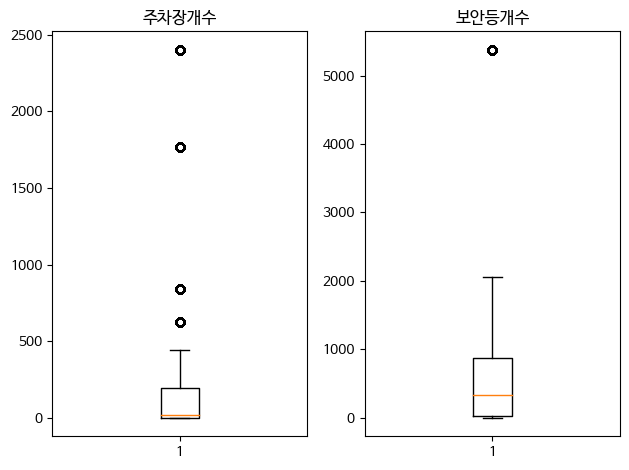

In [ ]:
plt.subplot(1,2,1)
plt.boxplot(train_raw['주차장개수'])
plt.title('주차장개수')
plt.subplot(1,2,2)
plt.boxplot(x = train_raw['보안등개수'])
plt.title('보안등개수')
plt.tight_layout()

**[해석]   **


---



1. 주차장개수와 보안등개수 모두 이상치 제거를 해야겠다고 확신.

In [ ]:
for i in ['주차장개수', '보안등개수']:
  Q1 = train_raw[i].quantile(0.25)
  Q3 = train_raw[i].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  train_raw[i] = train_raw[i].clip(lower=lower_bound, upper=upper_bound)

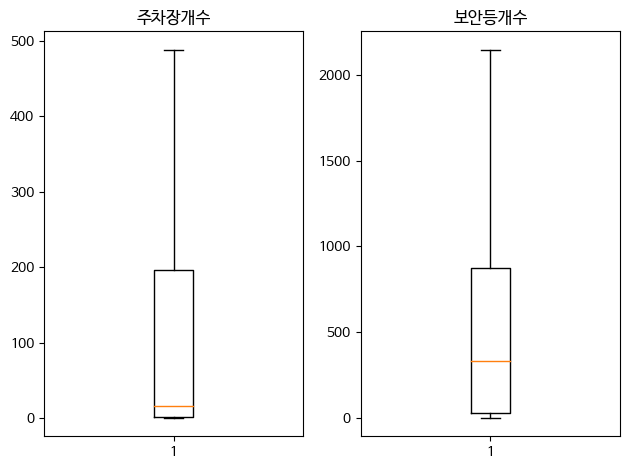

In [ ]:
plt.subplot(1,2,1)
plt.boxplot(train_raw['주차장개수'])
plt.title('주차장개수')
plt.subplot(1,2,2)
plt.boxplot(x = train_raw['보안등개수'])
plt.title('보안등개수')
plt.tight_layout()

**[해설]**


---

1. 이상치 제대로 제거 완료


In [ ]:
num_cols = train_raw.select_dtypes(exclude='object').columns.tolist()
cat_cols = train_raw.select_dtypes(include='object').columns.tolist()

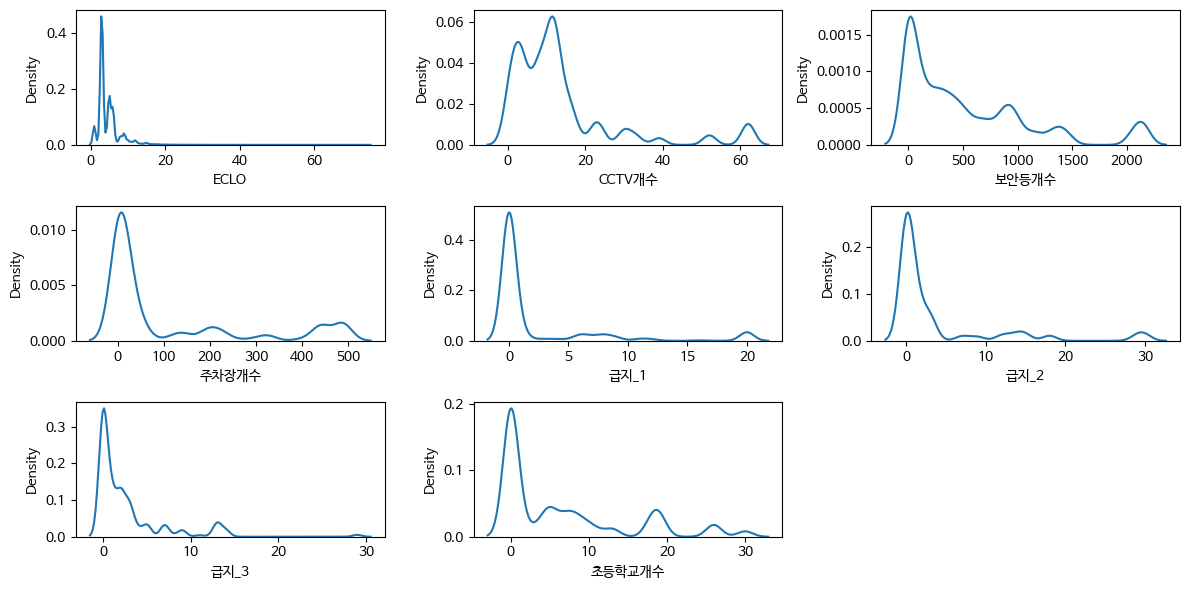

In [ ]:
i = 0
plt.figure(figsize=(12,6))
for col in num_cols:
    i += 1
    plt.subplot(3,3,i)
    sns.kdeplot(train_raw[col])
plt.tight_layout()

**[해석]**


---

1. 마찬가지로 큰 사고는 많이 없는 걸 확인할 수 있다.
2. CCTV개수가 적을수록 사고가 난 것을 확인할 수 있다.
3. 보안등개수가 적을수록 사고가 난 것을 확인할 수 있다.
4. 주차장 개수가 작을수록 사고가 난 것을 확인할 수 있다.
5. 초등학교 개수가 적을수록 사고가 많이 나는 것으로 보아, 초등학교 수가 많으면 좀 더 조심한다고 생각할 수 있을 것 같다.

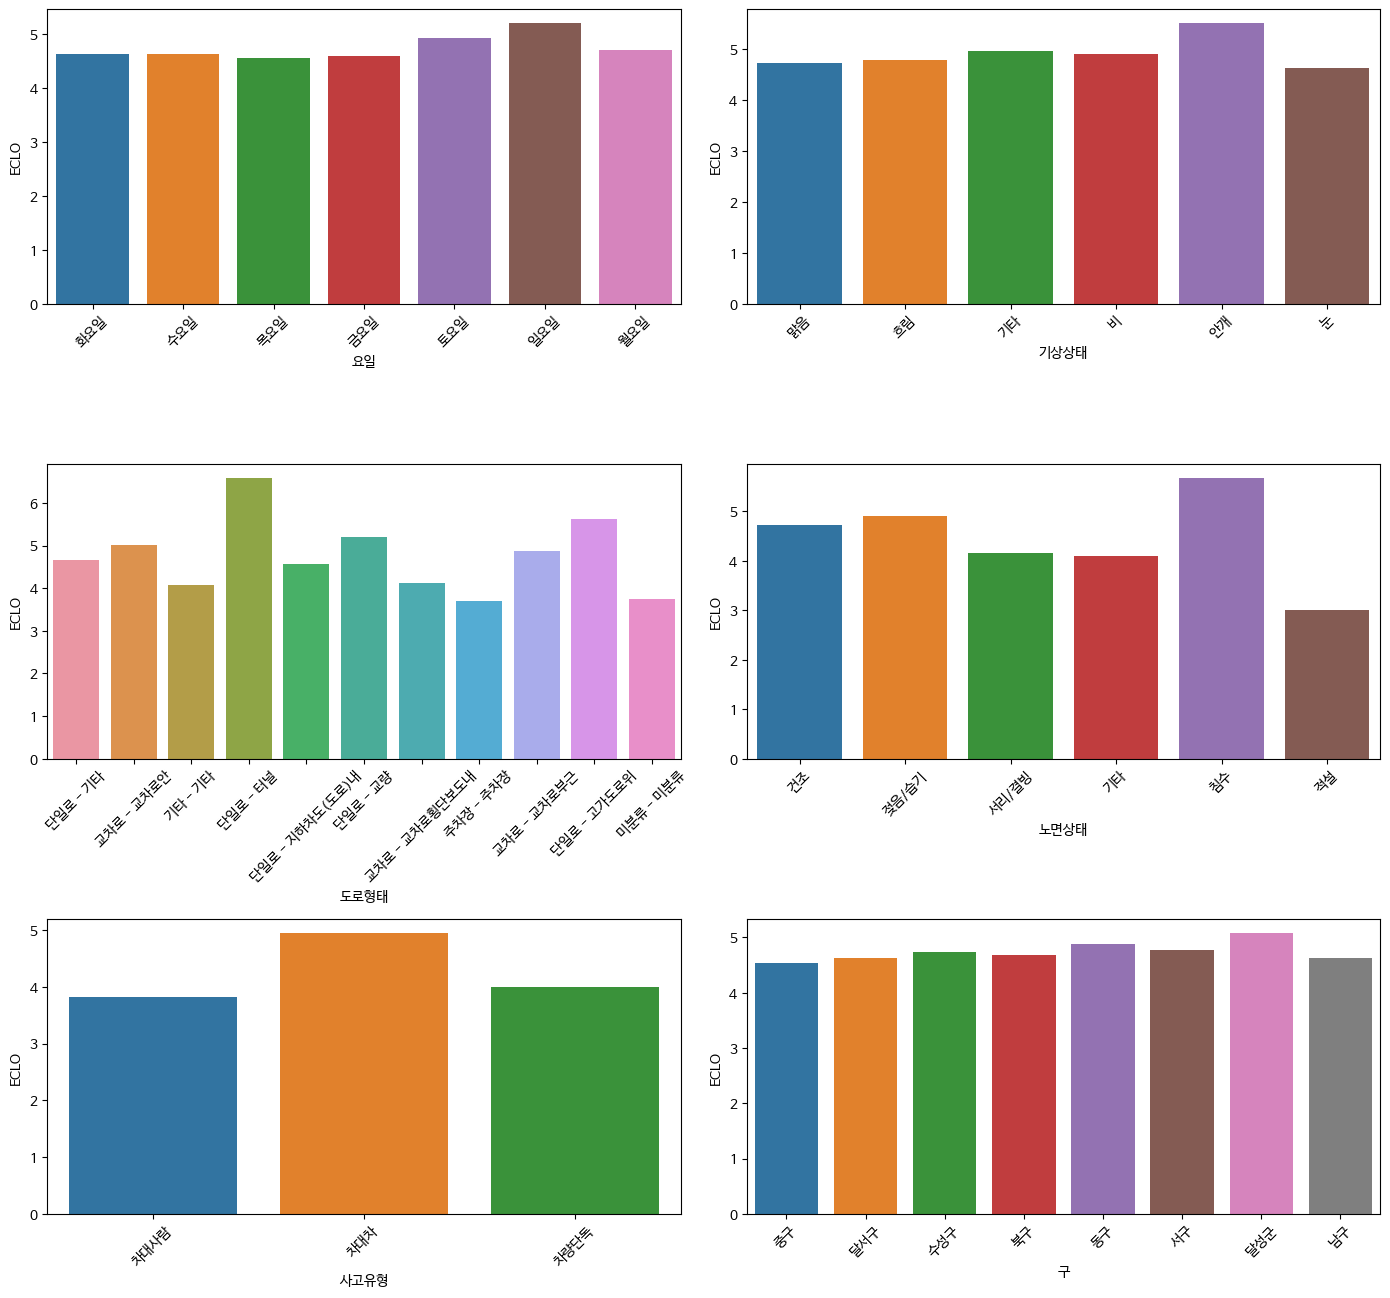

In [ ]:
i = 0
cols = ['요일','기상상태','도로형태','노면상태','사고유형','구']
plt.figure(figsize=(14,26))
for col in cols:
    i += 1
    plt.subplot(6,2,i)
    sns.barplot(x=train_raw[col], y=train_raw['ECLO'], errorbar=None)
    plt.xticks(rotation=45)
plt.tight_layout()

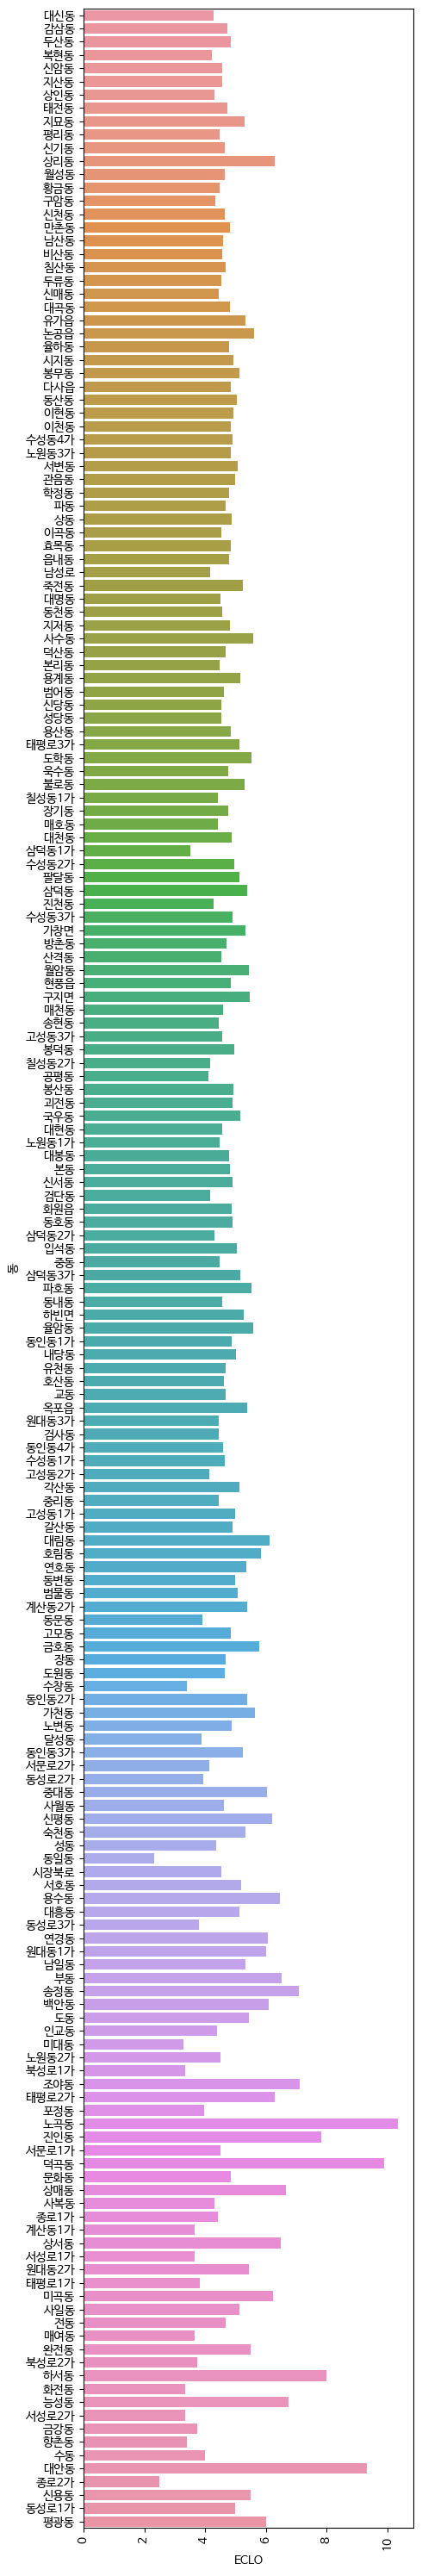

In [ ]:
plt.figure(figsize=(5, 30))
sns.barplot(x = train_raw['ECLO'], y = train_raw['동'], errorbar=None)
plt.xticks(rotation=90)
plt.tight_layout()

**[해석]**



---

1. 동에 따라서 ECLO 값의 차이가 많이 나는데, 동에 따라 target encoding을 수행해보면 어떨까라는 생각이 든다

In [ ]:
num_by_region = train_raw.groupby(['동'])['ECLO'].mean().sort_values(ascending=False)
print("높은 ECLO")
display(num_by_region[:10])
print()
print("낮은 ECLO")
display(num_by_region[-10:])

높은 ECLO


동
노곡동    10.333333
덕곡동     9.875000
대안동     9.333333
하서동     8.000000
진인동     7.823529
조야동     7.120000
송정동     7.071429
능성동     6.750000
상매동     6.666667
부동      6.515152
Name: ECLO, dtype: float64


낮은 ECLO


동
매여동      3.666667
삼덕동1가    3.511013
향촌동      3.400000
수창동      3.392857
서성로2가    3.333333
북성로1가    3.333333
화전동      3.333333
미대동      3.300000
종로2가     2.500000
동일동      2.333333
Name: ECLO, dtype: float64

In [ ]:
num_by_region = train_raw.groupby(['구'])['ECLO'].mean().sort_values(ascending=False)
print("높은 ECLO")
display(num_by_region[:10])
print()
print("낮은 ECLO")
display(num_by_region[-10:])

높은 ECLO


구
달성군    5.072280
동구     4.883878
서구     4.775680
수성구    4.727300
북구     4.686974
남구     4.623681
달서구    4.618441
중구     4.542388
Name: ECLO, dtype: float64


낮은 ECLO


구
달성군    5.072280
동구     4.883878
서구     4.775680
수성구    4.727300
북구     4.686974
남구     4.623681
달서구    4.618441
중구     4.542388
Name: ECLO, dtype: float64

**[해석]**


---

1. 구에 대해서는 target encoding을 하는게 좀 의미없어 보인다. 평균값이 거의 비슷해서 !


In [ ]:
train_raw['사고월'] = train_raw['사고월'].astype('int')
train_raw['사고일'] = train_raw['사고일'].astype('int')
train_raw['사고시간'] = train_raw['사고시간'].astype('int')

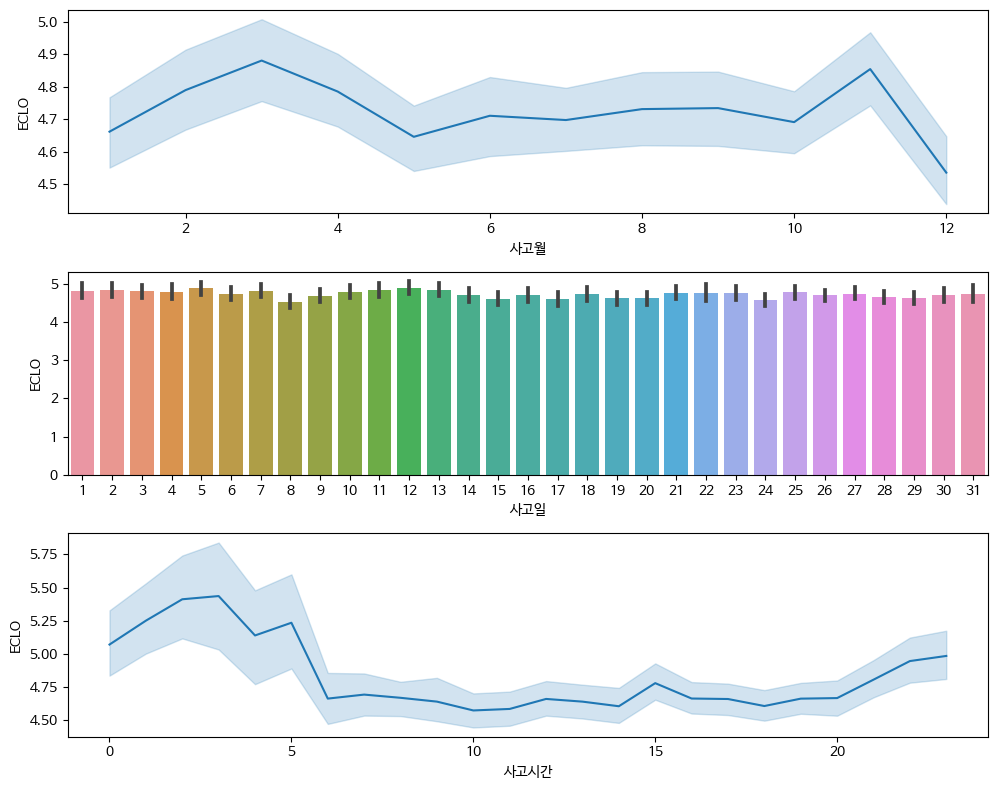

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
sns.lineplot(data=train_raw, x='사고월', y='ECLO')
plt.subplot(3,1,2)
sns.barplot(data=train_raw, x='사고일', y='ECLO')
plt.subplot(3,1,3)
sns.lineplot(data=train_raw, x='사고시간', y='ECLO')
plt.tight_layout();

**[해석]**


---

1. 3월, 11월에 사고가 상대적으로 크게 나는 것을 확인할 수 있음
2. 주로 새벽 시간에 사고가 상대적으로 크게 나는 것을 확인할 수 있음
3. 사고일로 봤을 때는 큰 특이점을 확인할 수 없는 것 같음

In [ ]:
i = 0
cols = ['CCTV개수','보안등개수','주차장개수','초등학교개수']
plt.figure(figsize=(12, 10))
for col in cols:
    i += 1
    plt.subplot(2,2,i)
    plt.scatter(x=train_raw[col],y=train_raw['ECLO'])
    # plt.xticks(rotation=45)
    plt.ylabel("ECLO");
    plt.legend([col]);
plt.tight_layout()

In [ ]:
plt.scatter(x=train_raw['급지_1'],y=train_raw['ECLO'])
plt.ylabel("ECLO");

plt.scatter(x=train_raw['급지_2'],y=train_raw['ECLO'])
plt.ylabel("ECLO");

plt.scatter(x=train_raw['급지_3'],y=train_raw['ECLO'])
plt.ylabel("ECLO");

plt.legend(['급지_1', '급지_2', '급지_3']);

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

mask = np.zeros_like(train_raw.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train_raw.corr(),
            cmap = 'bwr',
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )
plt.show()

'요일' -> 주말 1, 평일 0     
'기상상태' -> 안개 1, 나머지 0  
'도로형태'-> target encoding  
'노면상태'-> target encoding   
'사고유형' -> 차대차 1, 나머지 0   
'동'-> target encoding   


### EDA 기반 전처리 추가

In [ ]:
# ! pip install category_encoders
import category_encoders as ce

In [ ]:
train_raw['요일'] = ((train_raw['요일'] == '토요일')|(train_raw['요일'] == '일요일')).astype(int)
train_raw['기상상태'] = (train_raw['기상상태'] == '안개').astype(int)
train_raw['사고유형'] = (train_raw['사고유형'] == '차대차').astype(int)

In [ ]:
test_raw['요일'] = ((test_raw['요일'] == '토요일')|(test_raw['요일'] == '일요일')).astype(int)
test_raw['기상상태'] = (test_raw['기상상태'] == '안개').astype(int)
test_raw['사고유형'] = (test_raw['사고유형'] == '차대차').astype(int)

In [ ]:
for i in ['도로형태', '노면상태', '동']:
    le = ce.TargetEncoder(cols=[i])
    train_raw[i] = le.fit_transform(train_raw[i], train_raw['ECLO'])
    test_raw[i] = le.transform(test_raw[i])

In [ ]:
print(train_raw.columns)
print(test_raw.columns)

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '사고월', '사고일',
       '사고시간', '도시', '구', '동', 'CCTV개수', '보안등개수', '주차장개수', '급지_1', '급지_2',
       '급지_3', '초등학교개수'],
      dtype='object')
Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고월', '사고일', '사고시간', '도시',
       '구', '동', 'CCTV개수', '보안등개수', '주차장개수', '급지_1', '급지_2', '급지_3', '초등학교개수'],
      dtype='object')


In [ ]:
train_encode = train_raw.drop(['ID', '도시', '구'], axis = 1)
test_encode = test_raw.drop(['ID', '도시', '구'], axis = 1)

In [ ]:
print(train_encode.columns)
print(test_encode.columns)

Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '사고월', '사고일', '사고시간', '동',
       'CCTV개수', '보안등개수', '주차장개수', '급지_1', '급지_2', '급지_3', '초등학교개수'],
      dtype='object')
Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고월', '사고일', '사고시간', '동',
       'CCTV개수', '보안등개수', '주차장개수', '급지_1', '급지_2', '급지_3', '초등학교개수'],
      dtype='object')


In [ ]:
train_encode[['사고월', '사고일', '사고시간']] = train_encode[['사고월', '사고일', '사고시간']].apply(pd.to_numeric)
test_encode[['사고월', '사고일', '사고시간']] = test_encode[['사고월', '사고일', '사고시간']].apply(pd.to_numeric)

In [ ]:
with open(path + '/traindata_target.pkl', mode='wb') as f:
    pickle.dump(train_encode, f)
with open(path + '/testdata_target.pkl', mode='wb') as f:
    pickle.dump(test_encode, f)